In [937]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import seaborn as sns
from sklearn.model_selection import train_test_split # to make the test-train split of the data
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression # for the Logistic Regression model
from sklearn.metrics import roc_auc_score # to calculate an ROC value of our model
from sklearn.metrics import confusion_matrix, precision_score, recall_score # to make confusion matrix
from sklearn.utils import shuffle

In [938]:
# read in the clean data
loans_data_clean = pd.read_csv("../data/clean_data/lending_club_loans_cleaned.csv")
# make a working copy
df = loans_data_clean.copy()

In [939]:
df.shape

(40856, 14)

In [940]:
# decided to drop 'int_rate' as it is highly-correlated with fico
# decided to drop 'sub_grade' as it will create many dummy variables, and it is equivalent to fico
df.drop(['int_rate'], axis = 1, inplace = True)
# df.drop(['fico'], axis = 1, inplace = True)
#df.drop(['sub_grade'], axis = 1, inplace = True)
#df.drop(['pub_rec'], axis = 1, inplace = True)
#df.drop(['term'], axis = 1, inplace = True)
df.drop(['addr_state'], axis = 1, inplace = True)
# df.drop(['dti'], axis = 1, inplace = True)
# df.drop(['home_ownership'], axis = 1, inplace = True)
#df.drop(['emp_length'], axis = 1, inplace = True)
#df.drop(['annual_inc'], axis = 1, inplace = True)
#df.drop(['loan_amnt'], axis = 1, inplace = True)
#df.drop(['verification_status'], axis = 1, inplace = True)
# df.drop(['issue_yr'], axis = 1, inplace = True)

In [941]:
df.shape

(40856, 12)

In [942]:
df.columns

Index(['defaulted', 'loan_amnt', 'term', 'sub_grade', 'dti', 'fico', 'pub_rec',
       'emp_length', 'home_ownership', 'verification_status', 'annual_inc',
       'issue_yr'],
      dtype='object')

In [943]:
# pp.ProfileReport(df)

In [944]:
df = pd.get_dummies(df, drop_first = True)

df.head()

,defaulted,loan_amnt,dti,fico,pub_rec,annual_inc,issue_yr,term_60 months,sub_grade_A2,sub_grade_A3,...,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified
0,False,5000.0,27.65,735.0,0,24000,2011,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,True,2500.0,1.00,740.0,0,30000,2011,1,0,0,...,0,0,0,1,0,0,0,1,1,0
2,False,2400.0,8.72,735.0,0,12252,2011,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,False,10000.0,20.00,690.0,0,49200,2011,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,False,5000.0,11.20,730.0,0,36000,2011,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [945]:
# split our data into the predictor and outcome variables
loans_predictors = df.drop(columns = "defaulted")
loans_response = df["defaulted"]

In [946]:
# we are interested in a prediction model, so we will create a test and train split of the data
loans_pred_train, loans_pred_test, loans_resp_train, loans_resp_test = \
train_test_split(loans_predictors, loans_response, test_size = 0.2, random_state = 7)
# the training data is 80% of our starting dataset, the test data is 20% of our starting dataset
# we use 'random_state = 7' in order to ensure the random selection gives reproducible results

In [947]:
len(loans_pred_train)

32684

In [948]:
df['defaulted'].unique()

array([False,  True])

In [949]:
loans_train = pd.concat([loans_pred_train, loans_resp_train], axis = 1)
defaulted = loans_train.loc[df['defaulted'] == True] 
not_defaulted = loans_train.loc[df['defaulted'] == False] 

In [950]:
resample_defaulted = resample(defaulted, replace = True, n_samples = len(not_defaulted))

In [951]:
len(resample_defaulted)

27783

In [952]:
loans_train = pd.concat([not_defaulted, resample_defaulted], axis = 0)
loans_train

,loan_amnt,dti,fico,pub_rec,annual_inc,issue_yr,term_60 months,sub_grade_A2,sub_grade_A3,sub_grade_A4,...,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,defaulted
33881,13200.0,7.98,710.0,0,46596,2009,0,0,0,0,...,0,0,0,0,0,0,1,0,1,False
11614,16000.0,0.42,785.0,0,43000,2011,1,0,0,0,...,0,0,1,0,0,0,1,1,0,False
26708,10000.0,3.16,775.0,0,130000,2010,1,0,0,0,...,0,0,0,0,0,0,0,1,0,False
14876,9000.0,15.63,755.0,0,62400,2011,0,0,0,0,...,0,0,0,0,0,0,1,1,0,False
30905,8000.0,2.01,700.0,0,420000,2010,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19100,15000.0,8.64,705.0,0,75000,2011,0,0,0,0,...,0,0,0,0,0,0,1,1,0,True
16941,7000.0,12.70,670.0,0,30720,2011,1,0,0,0,...,0,0,0,0,0,0,1,1,0,True
18363,5000.0,18.57,690.0,1,55000,2011,0,0,0,0,...,0,0,0,0,0,0,1,0,1,True
16499,16000.0,14.44,730.0,0,32000,2011,1,0,0,0,...,0,0,0,0,0,0,1,0,1,True


In [953]:
(loans_train['defaulted'].value_counts() / loans_train['defaulted'].count()) * 100

False    50.0
True     50.0
Name: defaulted, dtype: float64

In [954]:
loans_train = shuffle(loans_train)

In [955]:
loans_resp_train = loans_train.loc[:,'defaulted']
loans_pred_train = loans_train.drop(['defaulted'], axis = 1)


In [956]:
loans_pred_train

,loan_amnt,dti,fico,pub_rec,annual_inc,issue_yr,term_60 months,sub_grade_A2,sub_grade_A3,sub_grade_A4,...,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified
12064,35000.0,11.71,680.0,0,88000,2011,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
14558,19700.0,19.90,750.0,0,37800,2011,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
28768,6000.0,23.69,675.0,1,69500,2010,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7500,14400.0,16.69,715.0,0,45000,2011,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
38879,21600.0,1.64,730.0,0,150000,2010,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27967,20000.0,17.54,710.0,0,86004,2010,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
26102,6000.0,12.15,730.0,0,39996,2010,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
20498,3700.0,21.39,735.0,0,40000,2010,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
13768,15850.0,17.91,715.0,0,96772,2011,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [957]:
# Logistic regression is the appropriate regression analysis to conduct when ...
# ...the dependent variable is dichotomous (binary). 
# building the Logistic Regression model

model = LogisticRegression()

model.fit(loans_pred_train, loans_resp_train)

LogisticRegression()

In [958]:
# the model accuracy on the training data
train_score = model.score(loans_pred_train, loans_resp_train)
train_score

0.5979375877335061

In [959]:
# the accuracy on the test data
test_score = model.score(loans_pred_test, loans_resp_test)
test_score

0.5603279490944689

In [960]:
# to prepare for calculation of the ROC, let's get the predicted proabilities of default from the model
pred_test = model.predict_proba(loans_pred_test)
# we have a 2d array where each row sums to 1, but we only want the second value (whether a loan defaults or not)
pred_test = pred_test[:, 1]
# now to calculate the ROC
AUC_score = roc_auc_score(y_true = loans_resp_test, y_score = pred_test)
print(AUC_score)
# the AUC score of 0.62 indicates some predictive power of the model

0.6429992647829188


In [961]:

# model = LogisticRegression()
fit = model.fit(loans_pred_train, loans_resp_train)

pd.DataFrame(
  {
  "Variable" : loans_pred_train.columns.values,
  "Coefficient" : fit.coef_[0],
  "Standardised": np.std(loans_pred_train, 0)*fit.coef_[0]
  }
)

,Variable,Coefficient,Standardised
loan_amnt,loan_amnt,3.898431e-05,2.991725e-01
dti,dti,5.472478e-04,3.668739e-03
fico,fico,-1.328713e-02,-4.652535e-01
pub_rec,pub_rec,4.130470e-05,1.101270e-05
annual_inc,annual_inc,-4.165147e-06,-2.075297e-01
issue_yr,issue_yr,4.589195e-03,4.654218e-03
term_60 months,term_60 months,1.465118e-04,6.791390e-05
sub_grade_A2,sub_grade_A2,-2.513898e-05,-4.015670e-06
sub_grade_A3,sub_grade_A3,-2.933738e-05,-5.066724e-06
sub_grade_A4,sub_grade_A4,-4.526628e-05,-1.001008e-05


In [962]:
loans_resp_test

25244    False
1791     False
12386     True
9703     False
23083    False
         ...  
40482    False
4167     False
28940    False
18454    False
21639    False
Name: defaulted, Length: 8172, dtype: bool

In [963]:
pred_test

array([0.47806178, 0.61430839, 0.4720626 , ..., 0.4650737 , 0.40044027,
       0.30863747])

In [964]:
# to prepare for calculation of the ROC, let's get the predicted proabilities of default from the model
pred_test = model.predict(loans_pred_test)


cf_matrix = confusion_matrix(loans_resp_test, pred_test)
print(cf_matrix)


[[3733 3173]
 [ 420  846]]


<AxesSubplot:>

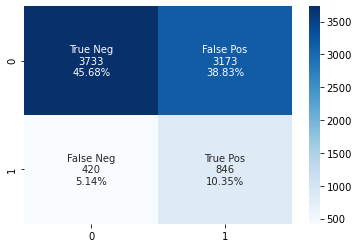

In [965]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [966]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(loans_resp_test, pred_test)


0.5603279490944689

In [967]:
# Recall
# want to optimise for this, as it's better to turn down a loan applicant who would have repaid (False Pos), than to 
# approve an applicant who defaults (False Neg).  Recall score = TP / (TP + FN)
from sklearn.metrics import recall_score
recall_score = recall_score(loans_resp_test, pred_test)
print(recall_score)

0.6682464454976303


In [968]:
# Precision
from sklearn.metrics import precision_score
pred_series_test = pd.Series(pred_test)
precision_score(loans_resp_test, pred_series_test)


0.21050012440905697

In [969]:
pred_series_test.unique()

array([False,  True])

In [970]:
print(round(train_score, 2)*100, round(test_score, 2) * 100, round(AUC_score, 2) * 100, round(recall_score, 2) * 100)

60.0 56.00000000000001 64.0 67.0


In [971]:
# decided to drop 'int_rate' as it is highly-correlated with fico
# decided to drop 'sub_grade' as it will create many dummy variables, and it is equivalent to fico
df.drop(['int_rate'], axis = 1, inplace = True)
# df.drop(['fico'], axis = 1, inplace = True)
df.drop(['sub_grade'], axis = 1, inplace = True)
df.drop(['pub_rec'], axis = 1, inplace = True)
df.drop(['term'], axis = 1, inplace = True)
df.drop(['addr_state'], axis = 1, inplace = True)
# df.drop(['dti'], axis = 1, inplace = True)
# df.drop(['home_ownership'], axis = 1, inplace = True)
df.drop(['emp_length'], axis = 1, inplace = True)
df.drop(['annual_inc'], axis = 1, inplace = True)
df.drop(['loan_amnt'], axis = 1, inplace = True)
df.drop(['verification_status'], axis = 1, inplace = True)
# df.drop(['issue_yr'], axis = 1, inplace = True)

KeyError: "['int_rate'] not found in axis"